<a href="https://colab.research.google.com/github/saritmaitra/Buy_Sell_Signals/blob/master/buy_%26_sell_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pandas import DataFrame 
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import pandas_datareader as web
!pip install plotly
import plotly.graph_objects as go

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [75]:
print("....Data Loading...."); print();
print('\033[4mCrude Oil Spot Price\033[0m');
data = web.DataReader('^GSPC', data_source = 'yahoo', start = '2000-01-01')
data

....Data Loading....

Crude Oil Spot Price


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971
...,...,...,...,...,...,...
2020-12-31,3760.199951,3726.879883,3733.270020,3756.070068,3172510000,3756.070068
2021-01-04,3769.989990,3662.709961,3764.610107,3700.649902,5006680000,3700.649902
2021-01-05,3737.830078,3695.070068,3698.020020,3726.860107,4582620000,3726.860107


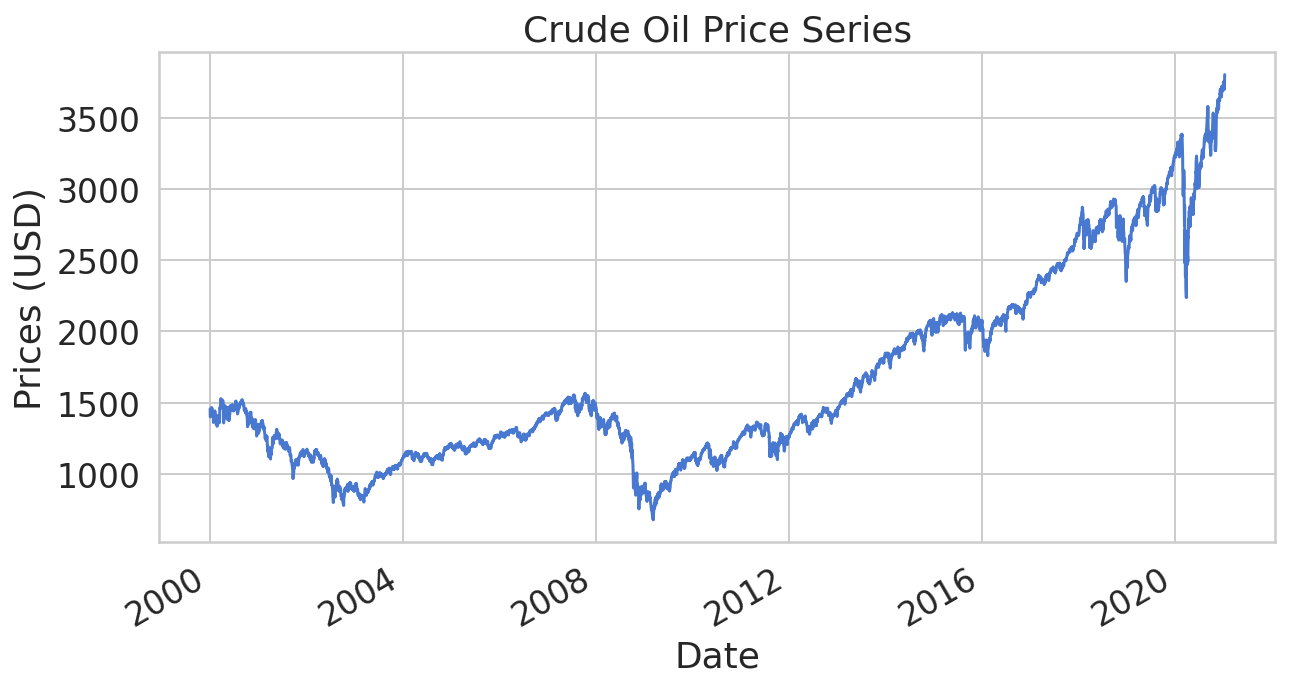

In [76]:
df = data[['Close']]

# Plot the closing price 
df.Close.plot(figsize=(10, 5))
plt.ylabel("Prices (USD)")
plt.title("Crude Oil Price Series")
plt.show();

In [77]:
df.loc[:,'ema10'] = (df.loc[:,'Close'].ewm(span=10,adjust=True,ignore_na=True).mean())
df.loc[:,'ema20'] = (df.loc[:,'Close'].ewm(span=20,adjust=True,ignore_na=True).mean())


df.loc[:, 'price_tomorrow'] = df.loc[:,'Close'].shift(-1)

df.dropna(inplace=True)
X = np.array(df[['ema10', 'ema20']])

# Define dependent variable
y = np.array(df['price_tomorrow'])

In [78]:
fig = go.Figure(data=[go.Candlestick(x=data.index[-100:],
                                     open=data['Open'][-100:],
                                     high=data['High'][-100:],
                                     low=data['Low'][-100:],
                                     close=data['Close'][-100:])])
fig.add_trace(
        go.Scatter(x = df.index[-100:], y = df.ema10[-100:], marker = dict(color = "blue"), name = "EMA10"))
fig.add_trace(
        go.Scatter(x = df.index[-100:], y = df.ema20[-100:], marker = dict(color = "gray"), name = "EMA10"))
fig.update_xaxes(
        showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(
        showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(
        autosize = False, width = 1200, height = 600)
fig.update_layout(
        title='Candlestick plot::Crude oil prices', yaxis_title='(US$)')

plt.show();

In [79]:
fig = go.Figure(
    data=[go.Candlestick(x=data.index[-100:],
    open=data['Open'][-100:], 
    high=data['High'][-100:], 
    low=data['Low'][-100:], 
    close=data['Close'][-100:])]
    )
fig.add_trace(go.Scatter(x = df.index[-100:], y = df.ema10[-100:], marker = dict(color = "blue"), name = "EMA10"))
fig.add_trace(go.Scatter(x = df.index[-100:], y = df.ema20[-100:], marker = dict(color = "gray"), name = "EMA10"))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(autosize = False, width = 1200, height = 600)
fig.update_layout(title='Crude oil prices, yaxis_title=(US)')
fig.show();

In [80]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size = 0.80, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

TimeSeriesSplit(max_train_size=0.8, n_splits=5)

Length train set: 3966
Length test set: 1321


In [81]:
from sklearn.linear_model import LinearRegression, ElasticNet

# Create a linear regression model
model = ElasticNet(max_iter=5000, random_state=0).fit(X_train, y_train)
print("Linear Regression model:")
print("Crude oil Price (y) = %.2f * 10 Days Moving Average (x1) \
+ %.2f * 20 Days Moving Average (x2) \
+ %.2f (constant)" % (model.coef_[0], model.coef_[1], model.intercept_))

Linear Regression model:
Crude oil Price (y) = 1.95 * 10 Days Moving Average (x1) + -0.95 * 20 Days Moving Average (x2) + 3.50 (constant)


In [82]:
y_pred = DataFrame(model.predict(X_test), index = df[-len(y_test):].index, columns = ['price'])
y_test = DataFrame(y_test, index = df[-len(y_test):].index, columns = ['price'])

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_pred.index, y = y_pred.price,
                         marker = dict(color ="red"), name = "Actual price"))
fig.add_trace(go.Scatter(x = y_test.index, y = y_test.price, marker=dict(
        color = "green"), name = "Predicted price"))

fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_layout(
    title= "Crude oil price (predicted vs actual", 
    yaxis_title = 'price (US$)',
    hovermode = "x",
    hoverdistance = 100, # Distance to show hover label of data point
    spikedistance = 1000) 
fig.update_layout(autosize = False, width = 1000, height = 400,)
fig.show()

In [84]:
accuracy = model.score(X_test, y_test)
print("Accuracy: ", round(accuracy*100,2).astype(str) + '%')

Accuracy:  98.96%


Text(0, 0.5, 'Cumulative Returns')

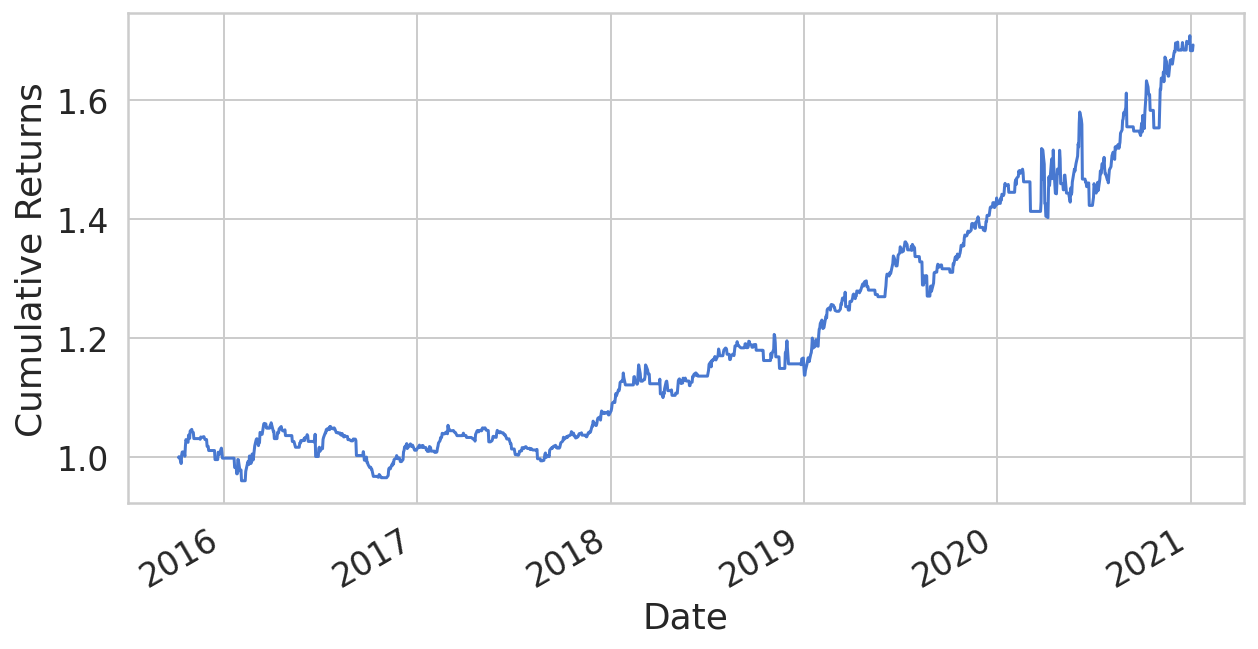

In [85]:
oil = DataFrame()

oil['price'] = df[-len(y_test):]['Close']
oil['pred_next_day'] = y_pred
oil['actual_price_next_day'] = y_test
oil['returns'] = oil['price'].pct_change().shift(-1)
oil['signal'] = np.where(oil.pred_next_day.shift(1) < oil.pred_next_day,1,0)
oil['strategy_returns'] = oil.signal * oil['returns']
((oil['strategy_returns']+1).cumprod()).plot(figsize=(10,5))
plt.ylabel('Cumulative Returns')
plt.show()

In [86]:
'Sharpe Ratio %.2f' % (oil['strategy_returns'].mean()/oil['strategy_returns'].std()*(252**0.5))

'Sharpe Ratio 0.97'

In [87]:
df.loc[:,'pred_price'] = model.predict(df[['ema10', 'ema20']])
df.loc[:,'signal'] = np.where(df.pred_price.shift(1) < df.pred_price,"Buy","Sell")
df.loc[:,'price_direction'] = df['signal'].replace(('Sell', 'Buy'), (0, 1))
df.tail()

,Close,ema10,ema20,price_tomorrow,pred_price,signal,price_direction
Date,,,,,,,
2020-12-30,3732.040039,3709.332516,3684.744108,3756.070068,3726.619217,Buy,1
2020-12-31,3756.070068,3717.830253,3691.537057,3700.649902,3736.712355,Buy,1
2021-01-04,3700.649902,3714.706553,3692.404947,3726.860107,3729.810057,Sell,0
2021-01-05,3726.860107,3716.916290,3695.686391,3748.139893,3730.997436,Buy,1
2021-01-06,3748.139893,3722.593309,3700.681963,3803.790039,3737.306314,Buy,1


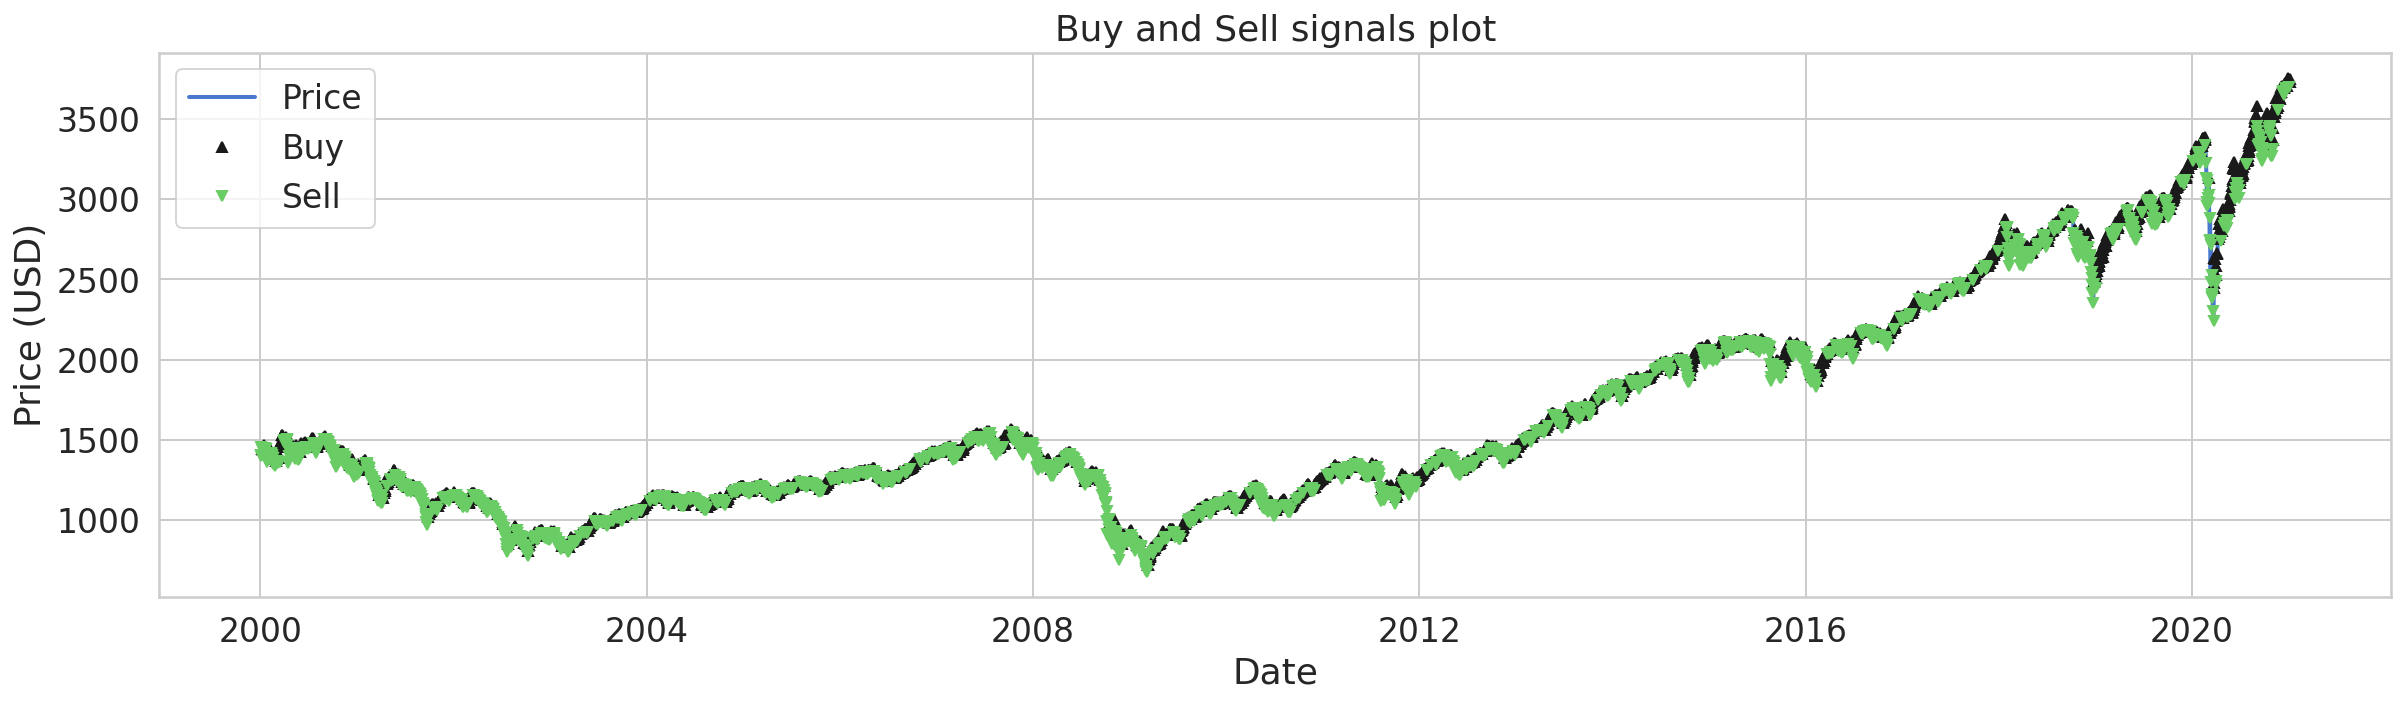

In [88]:
buys = df.loc[df['price_direction'] == 1]
sells = df.loc[df['price_direction'] == 0]

# Plot 
fig = plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Close'], lw=2., label='Price')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Close'], 
         '^', markersize=5, color='k', lw=2., label='Buy')
plt.plot(sells.index, df.loc[sells.index]['Close'], 
         'v', markersize=5, color='g', lw=2., label='Sell')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.title('Buy and Sell signals plot')
plt.legend(loc='best')

# Display everything
plt.show();

In [89]:
print('Data shape:', df.shape); print();
X = np.array(df[['ema10', 'ema20']])

# Define dependent variable
y = np.array(df['price_direction'])

Data shape: (5287, 7)



In [90]:
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size = 0.80, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

print('Length train set: {}'.format(len(y_train)))
print('Length test set: {}'.format(len(y_test)))

TimeSeriesSplit(max_train_size=0.8, n_splits=5)

Length train set: 3966
Length test set: 1321


In [91]:
# Use Cross-validation/backtesting.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std


print('\033[4mLogistic Regression\033[0m')
model_clf = LogisticRegression(solver='liblinear', C=0.05, random_state=0).fit (X_train,y_train)

model_scores = cross_val_score(model_clf, X_train, y_train, cv=5);
model_mean = model_scores.mean();
print ('Accuracy score (%):', model_mean*100); 

Logistic Regression
Accuracy score (%): 66.91869347978694


In [92]:
y_pred = model_clf.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.31%


In [93]:
# Run the code to view the classification report metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred)); print();
print ('Classification report:')
print (classification_report(y_test, y_pred))

Confusion matrix:
[[197 248]
 [131 745]]

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.44      0.51       445
           1       0.75      0.85      0.80       876

   micro avg       0.71      0.71      0.71      1321
   macro avg       0.68      0.65      0.65      1321
weighted avg       0.70      0.71      0.70      1321



In [94]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(y_test,y_pred)))

Precision score: 0.7502517623363545


In [95]:
print('\033[4mProbability of prediction results\033[0m')

predict_prob = model.predict(X_test)
fd = pd.DataFrame(predict_prob)
# fd['actual'] = df
fd.tail


Probability of prediction results


<bound method NDFrame.tail of                 0
0     1970.861199
1     1982.966189
2     1993.127829
3     1997.413976
4     1998.176958
...           ...
1316  3726.619217
1317  3736.712355
1318  3729.810057
1319  3730.997436
1320  3737.306314

[1321 rows x 1 columns]>

In [96]:
df

,Close,ema10,ema20,price_tomorrow,pred_price,signal,price_direction
Date,,,,,,,
2000-01-03,1455.219971,1455.219971,1455.219971,1399.420044,1454.976561,Sell,0
2000-01-04,1399.420044,1424.530011,1425.925009,1402.109985,1423.042143,Sell,0
2000-01-05,1402.109985,1415.517310,1417.180275,1403.449951,1413.798407,Sell,0
2000-01-06,1403.449951,1411.541653,1413.216543,1441.469971,1409.821660,Sell,0
2000-01-07,1441.469971,1420.133259,1420.050807,1457.599976,1420.058282,Buy,1
...,...,...,...,...,...,...,...
2020-12-30,3732.040039,3709.332516,3684.744108,3756.070068,3726.619217,Buy,1
2020-12-31,3756.070068,3717.830253,3691.537057,3700.649902,3736.712355,Buy,1
2021-01-04,3700.649902,3714.706553,3692.404947,3726.860107,3729.810057,Sell,0


In [97]:
df['off'] = np.abs(df.price_tomorrow - df.pred_price)
df['per_off'] = (df['off'] / df['price_tomorrow']) *100
df


,Close,ema10,ema20,price_tomorrow,pred_price,signal,price_direction,off,per_off
Date,,,,,,,,,
2000-01-03,1455.219971,1455.219971,1455.219971,1399.420044,1454.976561,Sell,0,55.556517,3.969967
2000-01-04,1399.420044,1424.530011,1425.925009,1402.109985,1423.042143,Sell,0,20.932158,1.492904
2000-01-05,1402.109985,1415.517310,1417.180275,1403.449951,1413.798407,Sell,0,10.348456,0.737358
2000-01-06,1403.449951,1411.541653,1413.216543,1441.469971,1409.821660,Sell,0,31.648311,2.195558
2000-01-07,1441.469971,1420.133259,1420.050807,1457.599976,1420.058282,Buy,1,37.541694,2.575583
...,...,...,...,...,...,...,...,...,...
2020-12-30,3732.040039,3709.332516,3684.744108,3756.070068,3726.619217,Buy,1,29.450851,0.784087
2020-12-31,3756.070068,3717.830253,3691.537057,3700.649902,3736.712355,Buy,1,36.062453,0.974490
2021-01-04,3700.649902,3714.706553,3692.404947,3726.860107,3729.810057,Sell,0,2.949950,0.079154


In [98]:
(np.mean(df.off.cumsum())*2)**0.5

285.0371045809283

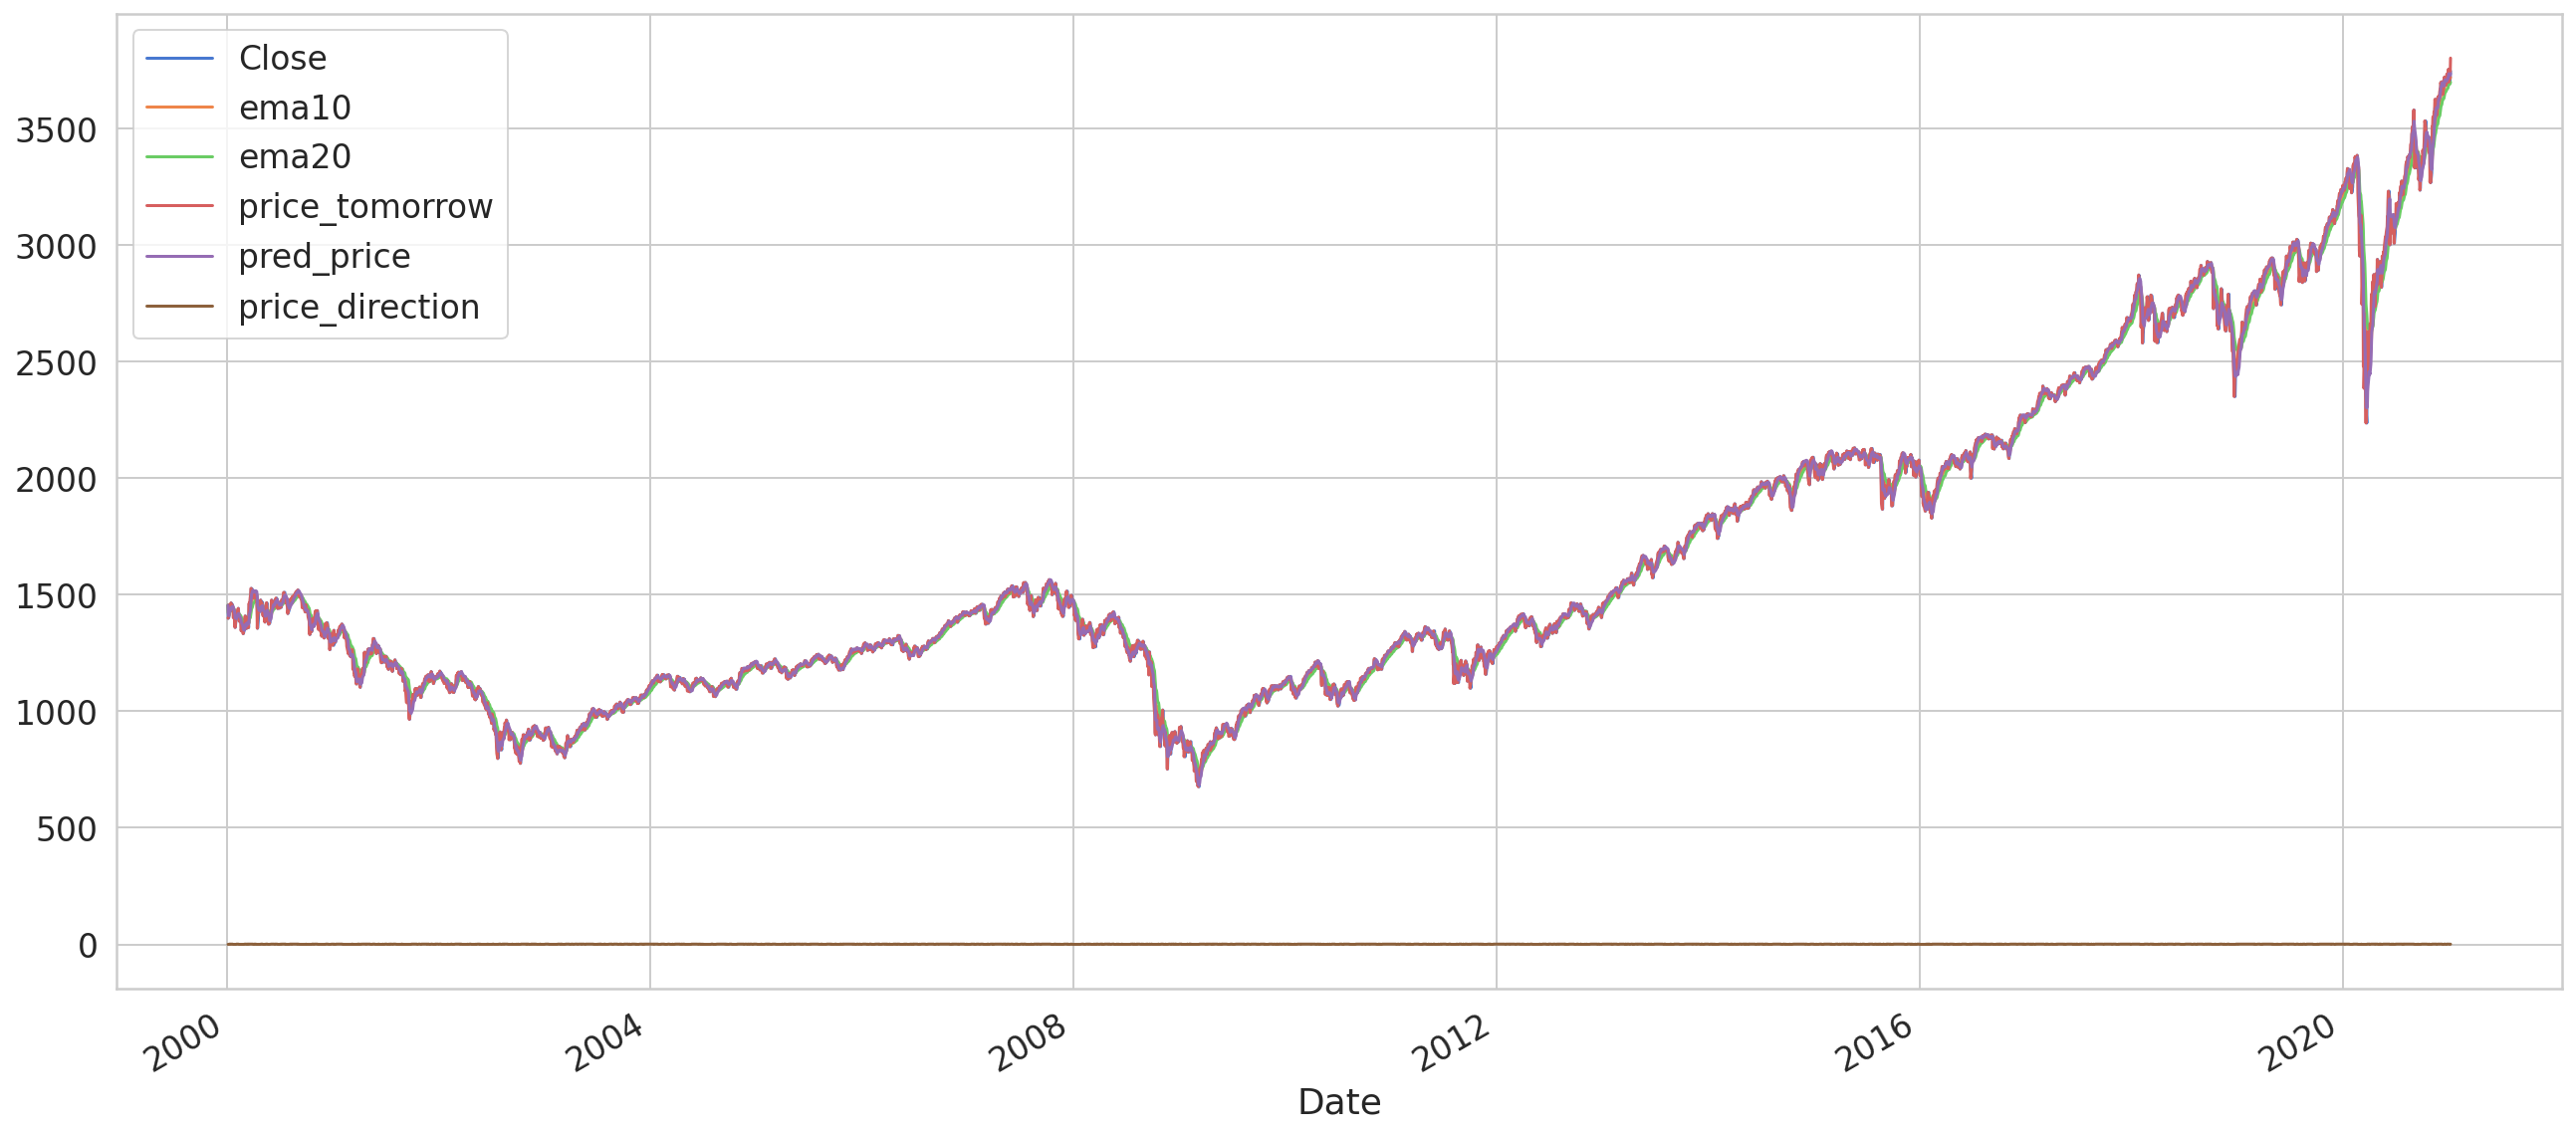

In [57]:
df.plot()